In [1]:
import copy
import numpy as np
import gpstk
import pandas as pd
from sympy import *
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from numba import autojit
from numpy.linalg import norm
%matplotlib inline
init_printing(use_latex=True)

In [2]:
def TableUDREI(UDREIs):
    inicio = 0.75
    UDRE_mts = []
    UDRE_sigma = []
    T_UDRE = [0.75,1.,1.25,1.75,2.25,3.,3.75,4.5,5.25,6.,7.5,15.,50.,150,0,0]
    T_sigma = [0.0520,0.0924,0.1444,0.2830,0.4678,0.8315,1.2992,1.8709,2.5465,3.3260,5.1968,20.7870,230.9661,2078.695,0,0]
    for i in range (0,len(UDREIs)):
        UDRE_mts.append(T_UDRE[int(UDREIs[i])])
        UDRE_sigma.append(T_sigma[int(UDREIs[i])])
    return UDRE_mts,UDRE_sigma

In [4]:
#functions for calculate position
@autojit
def apply_earth_rotation_to_svs_position(svs, prs):
    c = 299792458
    we = 7.2921159e-5
    rpos = np.zeros(svs.shape)
    pos = np.array(svs)
    for i in range(len(pos)):
        dt = prs[i]/c
        theta = we*dt
        R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
        rpos[i] = R.dot(pos[i])
    svs = np.array(rpos)
    return svs
@autojit
def compute_distances(rc, svs):
    # return np.array( [np.sqrt((rc[0]-sv[0])**2 + (rc[1]-sv[1])**2) for sv in svs] )
    return np.linalg.norm(rc-svs, axis=1) #raiz cuadrada de la suma de los cuadrados de los puntos para medir distancia.
@autojit
def predict_pseudoranges(x, prns_pos, prns_clockbias):
    c = 299792458
    rhos    = compute_distances(x[:3], prns_pos)
    pranges = rhos + x[3]-c*prns_clockbias
    #print "rhos: ",rhos
    #print "pranges: ", pranges
    return rhos, pranges
def compute_least_squares_position(svs, svs_clocks, prs, max_iters=200, apply_earth_rotation=True):

    #if apply_earth_rotation:
    svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters): #mientras el delta < 1e-8 y no llegue al maximo de iteraciones
        rhos, pranges = predict_pseudoranges(ri, svs, svs_clocks)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta
def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)
def compute_raim_position(gps_week, gps_sow, prns, prns_pos, pranges,  bcestore):
    if len(prns)==0 or len(prns_pos)==0:
        return np.array([0,0,0])
    t = gpstk.GPSWeekSecond(gps_week, gps_sow).toCommonTime()
    prnList = [gpstk.SatID(int(i[3:])) for i in prns]
    satVector = gpstk.seqToVector(list(prnList), outtype='vector_SatID')
    rangeVector = gpstk.seqToVector([float(i) for i in pranges])
    noTropModel = gpstk.ZeroTropModel()
    raimSolver = gpstk.PRSolution2()
    raimSolver.RAIMCompute(t, satVector, rangeVector, bcestore, noTropModel)   
    r = np.array([raimSolver.Solution[0], raimSolver.Solution[1], raimSolver.Solution[2]])
    return r
def To_WGS84(pos):
    newPosPZ = np.array([pos[0]-0.36,pos[1]+0.08,pos[2]+0.18])
    return newPosPZ

# <font color="purple">SBAS - Space-Based Augmentation System </font>

![img](img/GBASconcept.png)
![img1](img/SBASconcept.png)

The augmentation information provided by SBAS covers <b>corrections and integrity</b> for satellite <b>position</b> errors, satellite <b>clock/time</b> errors and errors induced by the <b>estimation of the delay of the signal while crossing the ionosphere</b>

![img](img/SBAS-GBAS.png)

- Mohinder S Grewal: 
pg 270: lo que se puede arreglar con SBAS, Clock error, Ephemeris, Code and Carrier, Signal distorsion, Bias, Ionosphere, Troposphere. 

![img](http://www.navipedia.net/images/b/b0/SBAS_architecture.png)

- <b>RIMS:</b> Ranging and Integrity Monitoring Station(s) <font color="blue">(34)</font>
- <b>NLES:</b> are the Navigation Land Earth Stations-<font color="blue">(6)</font>
- <b>MCC:</b> is the Mission and Control Center-<font color="blue">(4)</font>
- <b>EWAN:</b> EGNOS Wide-Area (communication) Network (EGNOS)-<font color="blue">(1)</font>

The <b>RIMS</b> tasks are to perform <b>pseudorange measure- ments</b>, demodulate navigation data, mitigate multipath and interference, verify signal integrity, and to packetize and transmit data to the <b>MCC</b> centers.
The <b>MCC</b> then sends all the data to the <b>NLES</b> stations. Every <b>MCC</b> has a backup station that can take over in the event of failure.

<font color="red">The <b>SBAS</b> space segment</font> is composed by several <font color="blue">geostationary satellites</font> in charge of broadcasting, over the service area, the SBAS navigation message. Typically, the SBAS satellites are <font color="blue">multi-purpose</font> (commercial communication) satellites that carry out an additional navigation payload capable to generate a GPS-like signal that retransmits to the users the navigation message generated on-ground.

To enhance the performance of the current <b>GNSS</b> with additional information to:
- Improve <b>INTEGRITY</b> via real-time monitoring 
- Improve <b>ACCURACY</b> via differential corrections 
- Improve <b>AVAILABILITY</b> and <b>CONTINUITY</b>

- <b>Accuracy:</b> Difference between the measured position at any given time to the actual or true position.
- <b>Integrity:</b> Ability of a system to provide timely warnings to users or to shut itself down when it should not be used for navigation. <font color="blue">GPS late 2 hours to notificate to user that to failed a satellite, GLONASS late 16 hours</font>
- <b>Continuity:</b> Ability of a system to perform its function without (unpredicted) interruptions during the intended operation.
- <b>Availability:</b> Ability of a system to perform its function at initiation of intended operation. System availability is the percentage of time that accuracy, integrity and continuity requirements are met.

![img](http://sbas-africa.avantiplc.com/wp-content/uploads/2015/10/sbas-coverage-map-02.png)

![img](img/sbasNames.png)

[Ref](http://mgex.igs.org/IGS_MGEX_Status_SBAS.html)

In [5]:
navfile = "glonass/badg3170.15n" 
obsfile = "glonass/badg3170.15o" 
glofile = "glonass/badg3170.15g" 
mfile = "glonass/badg3170.15m" 
dfile = "glonass/badg3170.15d" 
sfile = "glonass/badg3170.15s" 

#Repository for SBAS => http://sis-perfandata.cnes.fr/main_data.html
sbas_obs = "Rinex_Sbas/317-b/M1203170.15b" #13 nov 15 => EGNOS for European Union
sbas_nav = "Rinex_Sbas/317-h/M1203170.15h"
sbas_EGNOS = "Rinex_Sbas/315-h/M1203150.15h" #11 nov 15 => EGNOS 
sbas_WAAS = "Rinex_Sbas/315-h/M1333150.15h" #11 nov 15 => WAAS for EEUU


'''type of data:

d = Hatanaka-compressed observation data
f = Beidou navigation message data
g = GLONASS navigation message data 
h = SBAS payload navigation message data
l = GALILEO navigation message data 
m = meteorological data
n = GPS navigation message data
o = observation data
p = mixed GNSS navigation message data
q = QZSS navigation message data
s = observation summary files (extracted from RINEX header)'''
"files"

'files'

### SBAS Navigation File

- <b>SBAS navigation files are similar to Glonass ones</b>, in that both con- tain records of satellite position, velocity and accelerations.

In [6]:
!head -65 $sbas_nav #Navigation File of SBAS

     2.10           H                                       RINEX VERSION / TYPE
ExtractGEONav_1.14  CNES                20-Nov-15 02:46     PGM / RUN BY / DATE
 0.000000000000e+00 0.000000000000e+00      0    0 EGNOS  0 D-UTC A0,A1,T,W,S,U
                                                            END OF HEADER
20 15 11 13  0  0 16.0 0.000000000000E+00 0.000000000000E+00 4.320211000000E+05
    4.063672000000e+04 0.000000000000e+00 0.000000000000e+00 3.100000000000e+01
   -1.124591600000E+04 0.000000000000E+00 0.000000000000E+00-1.000000000000E+00
    0.000000000000E+00 0.000000000000E+00 0.000000000000E+00 3.100000000000E+01
20 15 11 13  0  2 56.0 0.000000000000E+00 0.000000000000E+00 4.321811000000E+05
    4.063672000000e+04 0.000000000000e+00 0.000000000000e+00 3.100000000000e+01
   -1.124591600000E+04 0.000000000000E+00 0.000000000000E+00-1.000000000000E+00
    0.000000000000E+00 0.000000000000E+00 0.000000000000E+00 3.200000000000E+01
20 15 11 13  0  5 36.0 0.000000000000E+00 0.0

![img](img/navHeader.png)

![img](img/navData.png)

In [7]:
!head -65 $sbas_WAAS #Navigation File of WAAS 11-NOV-2016

     2.10           H                                       RINEX VERSION / TYPE
ExtractGEONav_1.14  CNES                18-Nov-15 02:43     PGM / RUN BY / DATE
 0.000000000000e+00 0.000000000000e+00      0    0  WAAS  0 D-UTC A0,A1,T,W,S,U
                                                            END OF HEADER
33 15 11 11  0  3 12.0-3.818422555923E-08-4.547473508865E-12 2.593681000000E+05
   -5.796069680000e+03-8.481250000000e-04-7.250000000000e-07 0.000000000000e+00
   -4.173536576000E+04-5.008125000000E-03 1.750000000000E-07 4.096000000000E+03
   -1.505802800000E+03 1.193880000000E-01 7.937500000000E-06 4.600000000000E+01
33 15 11 11  0  7 28.0-3.911554813385E-08-2.728484105319E-12 2.596261000000E+05
   -5.796310560000e+03-1.035000000000e-03-7.125000000000e-07 0.000000000000e+00
   -4.173664208000E+04-4.966250000000E-03 2.000000000000E-07 4.096000000000E+03
   -1.474979200000E+03 1.214120000000E-01 7.750000000000E-06 4.700000000000E+01
33 15 11 11  0 11 44.0-3.958120942116E-08 0.0

In [8]:
!head -65 $sbas_obs

     2.10           B                                       RINEX VERSION / TYPE
ConsolideSBAS       CNES                15/11/20 02:40      PGM / RUN BY / DATE
                    SBAS consolidation file for PRN 120     COMMENT
                                                            END OF HEADER
120 15 11 13 00 00 00.1  L1    32     0   SBA
  4    53 12 80 38 00 00 00 00 3F E0 00 00 00 00 00 00 00 00
       00 00 00 03 BB BB BB 80 00 00 23 07 04 80
120 15 11 13 00 00 01.1  L1    32     0   SBA
  3    9A 0C BF E4 00 3F F4 01 BF F8 00 00 03 FF C0 00 00 40
       08 00 00 01 79 57 BB 97 95 7B 94 FF 63 C0
120 15 11 13 00 00 02.1  L1    32     0   SBA
 26    C6 6A 50 15 A0 8B 03 38 15 C0 8E 04 70 23 01 1C 08 E0
       38 01 E8 0F BF DF FE FF F7 80 0C A4 00 C0
120 15 11 13 00 00 03.1  L1    32     0   SBA
  2    53 0A BF E7 FE 00 00 00 00 03 FF 00 00 00 00 00 00 3F
       EB FC 7F ED A7 BB 9F BB B9 55 94 54 84 40
120 15 11 13 00 00 04.1  L1    32     0   SBA
  4    9A 10 80 3C 00 00 00

one message foe each second

### SBAS Observation File
[HELP](http://www.navipedia.net/index.php/The_EGNOS_SBAS_Message_Format_Explained)

![img](img/obsHeader.png)

![img](img/obsData.png)

#### The Message in Binary is separate like the next table

![img](img/SBASmesgFormat.png)

![img](img/RTCA.png)
http://infostore.saiglobal.com/store/details.aspx?ProductID=580789

A brief explanation of the different data fields is presented hereafter:

- <b>Preamble</b>. It is a unique 24–bit field, distributed over three successive words. The preamble sequence (in three consecutive words) is 01010011 (83) (hex 53)- 10011010 (154) (hex 9A)- 11000110 (198) (hex C6). It is assured that the start of the preamble is synchronous with a 6-second GPS sub-frame. Thus, the preamble allows the receiver to achieve frame synchronisation.
- <b>Message Type Identifier</b>. It is a 6-bit field, which permits up to <b>64 different messages</b> (identifiers 0 to 63). Depending on the message type, the information included in the Data field has different meaning. Even though <b>64 type messages are available</b>, only <b>20 are currently defined</b>.
- <b>Data Field</b>. It contains different corrections and integrity information that depends on the type of message. The specific content of this field will be addressed in the following sections.
- <b>Parity Information</b>. The 24 bits of the end of the message (CRC parity bits) provide protection against burst and random error. For more information on parity bits algorithm generator see MOPS
- In Repositories the project [goGPS](https://github.com/goGPS-Project) have the code in matlab for read the SBAS codes.

In [37]:
def Read_SBAS_obs(SBAS_File):
    FileObs = []
    with open(SBAS_File) as f:
        content = f.readlines()
        i = 0
        Row = 0
        msgHx = ""
        MT = ""
        info = ""
        SATID = []
        Year = []
        Month = []
        Day = []
        Hour = []
        Min = []
        Sec = []
        Band = []
        LDM = []
        FICI = []
        TSI = []
        MTs = []
        Mensaje = []
        for fila in content:
            i+= 1
            if i >= 5: # dont raead the header
                #each 3 rows have information
                Row+= 1
                if Row == 1:
                    info = fila.split()
                if Row == 2:
                    fila = fila.strip('\n')
                    fila = fila.strip('\t')
                    fila = fila.replace(" ","")
                    MT = (fila[0])
                    other = fila[1:]
                    msgHx += other
                if Row == 3:
                    #new = "".join(fila.split("\n"))
                    fila = fila.strip('\n')
                    fila = fila.strip('\t')
                    fila = fila.replace(" ","")
                    msgHx += fila
                    Row = 0
                    #if MT == "2" or MT == "3" or MT == "4" or MT == "5" or MT == "24" or MT == "18" or MT == "26":
                    
                    SATID.append(int(info[0]))
                    Year.append(int(info[1]))
                    Month.append(int(info[2]))
                    Day.append(int(info[3]))
                    Hour.append(int(info[4]))
                    Min.append(int(info[5]))
                    Sec.append(float(info[6]))
                    Band.append(info[7])
                    LDM.append(int(info[8]))
                    FICI.append(int(info[9]))
                    TSI.append(info[10])
                    MTs.append(int(MT))
                    Mensaje.append(msgHx)
                    msgHx = ""
                if i == 30000:
                    break
                RES = pd.DataFrame({"SATID":SATID ,
                                    "Year": Year, 
                                    "Month":Month,
                                    "Day": Day,
                                    "Hour": Hour,
                                    "Min": Min,
                                    "Sec": Sec,
                                    "Band": Band,
                                    "LDM": LDM,
                                    "FICI": FICI,
                                    "TSI": TSI,
                                    "MTs": MTs,
                                    "Mensaje": Mensaje,})
    return RES

In [38]:
DT_SBAS = Read_SBAS_obs(sbas_obs) #Read the File

In [39]:
DT_SBAS.tail()

,Band,Day,FICI,Hour,LDM,MTs,Mensaje,Min,Month,SATID,Sec,TSI,Year
9993,L1,13,0,2,32,3,530E8000000000000000000000000003FE4003FF0003BB...,46,11,120,33.1,SBA,15
9994,L1,13,0,2,32,2,9A098000017FE0003FD401C000000000003FDC00000B95...,46,11,120,34.1,SBA,15
9995,L1,13,0,2,32,4,C6128003FC8003FD7FD000000000000000000000000397...,46,11,120,35.1,SBA,15
9996,L1,13,0,2,32,2,65368C7FDFFEFFF7FFBFFDFFEFFF7FFBFFDFFEFFF7FFBF...,46,11,120,36.1,SBA,15
9997,L1,13,0,2,32,3,9A0C8000000000000000000000000003FE4003FF0003BB...,46,11,120,37.1,SBA,15


In [40]:
List_MTs = list(DT_SBAS.MTs)
print len(List_MTs)

9998


In [41]:
cantidad = 24*60*60 #cantidad de mensajes en el día
cantidad

In [14]:
#Example with the frst line of data
#hex1 = "53128038000000003FE00000000000000000" #first line MT 4
#hex2 = "00000003BBBBBB80000023070480"
hex1 = "9A0CBFE4003FF401BFF8000003FFC0000040" #second line MT 3
hex2 = "080000017957BB97957B94FF63C0"
#hex1 = "C66A5015A08B033815C08E047023011C08E0" #third line MT 26
#hex2 = "3801E80FBFDFFEFFF7800CA400C2"
#hex1 = "9A08BFE7FE0000000003FF0000000000003F" #Random line
#hex2 = "EFFCBFEDA7BB97BBB9559B9DFC00"
dec1 = int(hex1+hex2, 16) #hex to int
bina = '{0:04b}'.format(dec1)
msg = copy.copy(bina) #1010101010101.... (256 bits)
print len(hex1+hex2),"hexa, ","Size binary info: ",len(str(bina))

64 hexa,  Size binary info:  256


![img](img/MT.png)

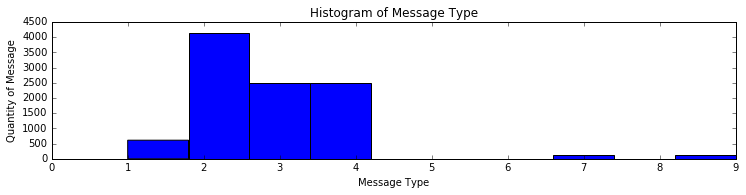

In [44]:
fig =plt.figure(figsize=(10,2))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.xlabel('Message Type')
plt.ylabel('Quantity of Message')
plt.title(r'Histogram of Message Type')
plt.hist(List_MTs, bins = 10)
plt.show()

![img](img/improveSBAS.png)

![img](img/Accuaracy_gps_egnos.png)

In [15]:
def Preamble(BinaryCode):
    return hex(int(BinaryCode[0:8],2))

def MessageType(BinaryCode):
    mt = int(BinaryCode[8:14], 2)
    
    labelmt = ""
    if mt==0:
        labelmt = "Don’t use for safety applications"
    if mt==1:
        labelmt = "PRN mask assignments, set up to 51 of 210 possible"
    if mt >= 2 and mt <= 5:
        labelmt = "Fast corrections"
    if mt==6:
        labelmt = "Integrity information"
    if mt==7:
        labelmt = "Fast correction degradation factor"
    if mt==9:
        labelmt = "Geo Navigation message (X,Y,Z, time, etc.)"
    if mt==10:
        labelmt = "Degradation parameters"
    if mt==12:
        labelmt = "SBAS Network time / UTC offset parameters"
    if mt==17:
        labelmt = "Geo satellite almanacs"
    if mt==18:
        labelmt = "Ionospheric grid points masks"
    if mt==24:
        labelmt = "Mixed fast corrections/long term satellite error corrections"
    if mt==25:
        labelmt = "Long term satellite error corrections"
    if mt==26:
        labelmt = "Ionospheric delay corrections"
    if mt==27:
        labelmt = "SBAS Service message"
    if mt==28:
        labelmt = "Clock Ephemeris Covariance Matrix message"
    if mt==62:
        labelmt = "Internal test message"
    if mt==63:
        labelmt = "Null message"
    return mt,labelmt
    
    
def IODP(BinaryCode):
    label = "OK"
    iodp = int(BinaryCode[224:226],2)
    if iodp == 3:
        label = "Problem with one or more SVs"
    
    return iodp,label

# <font color="red">HEADER - Message Type</font>

In [16]:
print "Preamble: ",Preamble(msg)
print "Message Type: ", MessageType(msg)
print "IODP: ", IODP(msg)

Preamble:  0x9a
Message Type:  (3, 'Fast corrections')
IODP:  (2, 'OK')


<b>Message type 1: </b>
Message type 1 includes the PRN mask assignments, chosen among the applicable GNSS and GEO satellites. Instead of sending for each correction the satellite PRN associated with, a mask is created to save space in the messages. This bit mask contains the i-th bit to 1 to inform that i-th satellite PRN is being used.
Although there are 210 slots (bits) in the mask, only a maximum of 51 can be set at a time due to constraint in the limited size available to broadcast information (message type 6 does only have enough free space to allocate UDREI figures for 51 satellites). Corrections are provided only for these satellites.
The user will read the mask and then each satellite correction will be related with the satellite via the mask contained in this message. IODP indicates the mask’s applicability to the corrections contained in the messages to which the mask applies. [PRN Slot list](https://github.com/mvglasow/satstat/wiki/NMEA-IDs)


In [17]:
'''%EGNOS MT1 message structure (PRN mask):
% 8 bit: preamble
% 6 bit: message type (MT)
% 32 bit: bit mask for GPS satellites, ordered from PRN 1 to 32
%   se bit = 0 -> SV to be disregarded
%   se bit = 1 -> SV to be used
%       es: 01111111111111111111111111111110
%       PRN 1  NOT available (bit 1 = 0)
%       PRN 2  available     (bit 2 = 1)
%       ...
%       PRN 31 available     (bit 31 = 1)
%       PRN 32 NOT available (bit 32 = 0)
% 180 bit: bit mask for other satellites (eg: GLONASS)
% 24 bit: parity
% TOTAL: 250 bit'''
"EGNOS MT1 (PRN mask)"

'EGNOS MT1 (PRN mask)'

In [18]:
'''NMEA IDs can be roughly divided into the following ranges:

1–32: GPS
33–54: Various SBAS systems (EGNOS, WAAS, SDCM, GAGAN, MSAS) – some IDs still unused
55–64: not used (might be assigned to further SBAS systems)
65–88: GLONASS
89–96: GLONASS (future extensions?)
97–192: not used
193–195: QZSS
196–200: QZSS (future extensions?)
201–235: Beidou'''
"NMEA IDs"

'NMEA IDs'

In [36]:
def PRNAvalible(BinaryCode,PRN_NMEA): #this is part of MT=1
    BinaryList = BinaryCode[14:14+235]
    label = "not-assigned"
    if PRN_NMEA == 1:
        res = BinaryList[0]
    else:
        res = BinaryList[PRN_NMEA-1:PRN_NMEA]
    if(PRN_NMEA>=1 and PRN_NMEA<=32):
        label = "GPS"
    if(PRN_NMEA>=65 and PRN_NMEA<=88):
        label = "GLONASS"
    if(PRN_NMEA>=196 and PRN_NMEA<=200):
        label = "QZSS"
    if(PRN_NMEA>=201 and PRN_NMEA<=235):
        label = "Beidou"
    return bool(res),label

## Message types 2 to 5:
Approximately the <b>$75 $%</b> of the data that sends the GEO contains only Fast Corrections data.

- <b>Pseudo Range Corrections (PRC):</b> to be added on the pseudorange of each satellite
- <b>User Differential Range Correction Indicators (UDREI):</b> are satellite health parameters which take values between 1 (very healthy) and 15 (do not use). Each value is equivalent to a certain weight to be applied on the weighting matrix (explained in detail in section 2.3. The SBAS Basic Positioning Equation). If it is equal to 14 it means that the satellite is not monitored and if it is equal to <b>15</b> it means that the satellite may be experiencing <b>technical problems</b> and its ranging data must not be used.
<b>differential corrections range: -256.000 a +255.875 [meters]</b>


The time of applicability of the fast corrections, which is used in fast correction computation, is defined as the start of the epoch of the SBAS Network Time (SNT) second that is coincident with the transmission of the first bit of the message block (bit belonging to the preamble) at the GEO satellite.
The message format is defined the section A.4.4.3 of MOPS, as well as the table that the SBAS user will consider to translate the $UDREI$ to a variance $σ^2UDRE$. Note that the status of the satellite is also included into the UDREI:
- <b>Use:</b> UDREIs from 0 to 13 indicates that the satellite is usable.
- <b>Not Monitored:</b> UDREI=14 indicates that the satellite does not appear in the mask or even appearing there are not corrections or UDRE values available for it.
- <b>Don’t Use:</b> UDREI=15 indicates that an inconsistency has been found for this satellite (alarm situation) or the estimated fast correction is greater than 256.0 m.

![img](img/MT2.png)

In [20]:
#This function is just is MT = 2,3,4,0
def MT2_FastCorrections(BinaryCode):
    iodp,_ = IODP(BinaryCode)
    #compute the PRC - PSEUDORANGE correction
    #start bit and end bit of the 13 PRCs in MT 2, 3, 4
    start_bit = np.linspace(19,163,13)
    end_bit   = np.linspace(30,174,13)
    #allocate the 13 binary numbers that correspond to the PRCs
    PRCs = []
    PRCs_b = []
    print "--------------Pseudorange Range Correction--------------"
    for j in range(0,13):
        print int(start_bit[j])," To ",int(end_bit[j])
        num_bin = msg[int(start_bit[j]-1):int(end_bit[j])]
        
        num_int = int(num_bin,2)
        res = 0.125 # LSB value = 0.125 (m)
        param_11 = 2047 #2^(n_bit-1) - 1
        #convert in twos complement
        p11 = num_int > param_11
        num_int = num_int - 4096 * int(p11)#4096 is 2^(11)
        PRC = num_int * res # meters
        
        PRCs.append(num_bin)
        PRCs_b.append(PRC)
        print "[",num_bin,"]", " PRC =>",PRC
        
    #start bit and end bit of the 13 UDREIs in MT 2, 3, 4
    start_bit_u = np.linspace(175,223,13)#[175 : 4 : 223];
    end_bit_u   = np.linspace(178,226,13)#[178 : 4 : 226];
    UDREIs = []
    UDREIs_b = []
    print "--------------UDREI--------------" #User Differential Range Error (meters)
    for j in range(0,13):
        print int(start_bit_u[j])," To ",int(end_bit_u[j])
        num_bin = msg[int(start_bit_u[j]-1):int(end_bit_u[j])]
        UDREIs.append(num_bin)
        UDREIs_b.append(int(num_bin,2))
        print "[",num_bin,"]", " to Int =>",int(num_bin,2)
    #WHAT SATELLITES?
    SV = []
    MT,_ = MessageType(msg)
    if MT == 2 or MT == 0:
        SV = range(1,14) #1 to 13
    elif MT == 3:
        SV = range(14,27) #14 to 26
    elif MT == 4:
        SV = range(27,40) #27 to 39
    elif MT == 5:
        SV = range(41,54) #41 to 53
    #SATELITES, UDREIs, 
    return SV,UDREIs_b,PRCs_b

In [21]:
#This function is just is MT = 24
def MT24_FastCorrections(BinaryCode):
    iodp,_ = IODP(BinaryCode)
    
    start_bit = np.linspace(15,75,6)
    end_bit   = np.linspace(26,86,6)
    #15   27   39   51   63   75
    #26   38   50   62   74   86
    
    PRCs = []
    for j in range(0,6):
        print int(start_bit[j])," To ",int(end_bit[j])
        num_bin = msg[int(start_bit[j]-1):int(end_bit[j])]
        
        num_int = int(num_bin,2)
        res = 0.125 # LSB value = 0.125 (m)
        param_11 = 2047 #2^(n_bit-1) - 1
        #convert in twos complement
        p11 = num_int > param_11
        num_int = num_int - 4096 * int(p11)#4096 is 2^(11)
        PRC = num_int * res # meters
        
        PRCs.append(PRC)
        print "[",num_bin,"]", " PRC =>",PRC
        
    start_bit_u = np.linspace(87,107,6)
    end_bit_u   = np.linspace(90,110,6)
    UDREIs = []
    for j in range(0,6):
        print int(start_bit_u[j])," To ",int(end_bit_u[j])
        num_bin = msg[int(start_bit_u[j]-1):int(end_bit_u[j])]
        UDREIs.append(num_bin)
        print "[",num_bin,"]", " to Int =>",int(num_bin,2)
    SV_block = [range(1,7),range(14,20),range(27,33)]
    iodp = int(BinaryCode[111:112],2)
    block_ID = int(BinaryCode[113:114],2) 
    SV = SV_block[block_ID+1]
    iodf = int(BinaryCode[115:116],2) 
    #NOTE:
    # IODF = 0,1,2: OK
    #      = 3:     problem with one or more SVs
    return SV,UDREIs,PRCs,iodp

In [22]:
sv,udreis,prcs = MT2_FastCorrections(msg) #Because MT for this e.g. is 3
mts,sigma = TableUDREI(udreis)
Results = pd.DataFrame({"Sat":sv ,"UDRE": udreis, "UDRE_Mts":mts, "UDRE_variance":sigma,"PRC [mts]":prcs})
Results

--------------Pseudorange Range Correction--------------
19  To  30
[ 111111111001 ]  PRC => -0.875
31  To  42
[ 000000000000 ]  PRC => 0.0
43  To  54
[ 111111111101 ]  PRC => -0.375
55  To  66
[ 000000000110 ]  PRC => 0.75
67  To  78
[ 111111111110 ]  PRC => -0.25
79  To  90
[ 000000000000 ]  PRC => 0.0
91  To  102
[ 000000000000 ]  PRC => 0.0
103  To  114
[ 111111111111 ]  PRC => -0.125
115  To  126
[ 000000000000 ]  PRC => 0.0
127  To  138
[ 000000000001 ]  PRC => 0.125
139  To  150
[ 000000000010 ]  PRC => 0.25
151  To  162
[ 000000000000 ]  PRC => 0.0
163  To  174
[ 000000000000 ]  PRC => 0.0
--------------UDREI--------------
175  To  178
[ 0101 ]  to Int => 5
179  To  182
[ 1110 ]  to Int => 14
183  To  186
[ 0101 ]  to Int => 5
187  To  190
[ 0101 ]  to Int => 5
191  To  194
[ 1110 ]  to Int => 14
195  To  198
[ 1110 ]  to Int => 14
199  To  202
[ 1110 ]  to Int => 14
203  To  206
[ 0101 ]  to Int => 5
207  To  210
[ 1110 ]  to Int => 14
211  To  214
[ 0101 ]  to Int => 5
215  T

,PRC [mts],Sat,UDRE,UDRE_Mts,UDRE_variance
0,-0.875,14,5,3,0.8315
1,0.000,15,14,0,0.0000
2,-0.375,16,5,3,0.8315
3,0.750,17,5,3,0.8315
4,-0.250,18,14,0,0.0000
5,0.000,19,14,0,0.0000
6,0.000,20,14,0,0.0000
7,-0.125,21,5,3,0.8315
8,0.000,22,14,0,0.0000
9,0.125,23,5,3,0.8315


![img](img/UDREI.png)

<b>UDRE</b> User Differential Range Error (meters) - estimates the uncertainty of the correction

### Comparing with SBAS TEACHER by [eesa](http://www.egnos-pro.esa.int/sbasteacher/)

![img](img/decode2A.JPG)

![img](img/decode2B.JPG)

![img](img/FastCorrection.png)

![img](img/MT18.png)

![img](img/MT26.png)

![img](img/IPP.png)

# IONO
![img](img/IONO.png)

### FOR <font color='red'>GPS</font>

In [23]:
navHeader, navData = gpstk.readRinex3Nav(navfile)
# setup ephemeris store to look for satellite positions (GPS)
bcestore = gpstk.GPSEphemerisStore()
GPS_LS = navHeader.leapSeconds
print "LEAP SECONDS GPS", GPS_LS
counter=0
InitialTimeGPS = bcestore.getInitialTime()
print "TIEMPO INICIAL", bcestore.getInitialTime()
print "TIEMPO FINAL", bcestore.getFinalTime()
for navDataObj in navData:
    counter += 1
    ephem = navDataObj.toGPSEphemeris()
    bcestore.addEphemeris(ephem)
    
    if(counter==3):
        print bcestore #print the bcstore for the trhee first ephemeris
bcestore.SearchNear()
print "conteo",counter
navData.close()

LEAP SECONDS GPS 17
TIEMPO INICIAL 3442448 00000000 0.000000000000000 GPS
TIEMPO FINAL 0000000 00000000 0.000000000000000 GPS
Dump of GPSEphemerisStore (detail level=1):
 BCE table for all satellites has 3 entries; Time span is 2015/11/12 08:00:00 GPS to 2015/11/13 04:00:00 GPS
 Search method is User
Sat G01 has   1 entries; Time span is 2015/11/13 00:00:00 GPS to 2015/11/13 00:00:00 GPS
Sat G02 has   1 entries; Time span is 2015/11/12 08:00:00 GPS to 2015/11/12 08:00:00 GPS
Sat G03 has   1 entries; Time span is 2015/11/13 02:00:00 GPS to 2015/11/13 02:00:00 GPS
END Dump of GPSEphemerisStore (detail level=1)

conteo 216


### FOR <font color='red'>GLONASS</font>

In [24]:
navHeader, navData = gpstk.readRinex3Nav(glofile) #glofile
# setup ephemeris store to look for satellite positions (GLONASS)
g = gpstk.GloEphemerisStore()
counter=0
Glo_LS = navHeader.leapSeconds #Leap Seconds, info in the header RINEX
timeSix = []

print "LEAP SECONDS Glonass", Glo_LS

for navDataObj in navData:
    counter += 1
    ephem = navDataObj.toGloEphemeris()
    tiempo = ephem.getEphemerisEpoch()
    xvt = ephem.svXvt(tiempo)
    freq = ephem.getfreqNum()
    g.addEphemeris(navDataObj)# object call g, have all the information of the Navigation file
    
    location = gpstk.Position(xvt.x)
    if(ephem.getPRNID() == 10):
        timeSix.append(tiempo.getSecondOfDay()) # keep in a array 
        print "PRN",ephem.getPRNID() #print the Satellite
        print "pos",xvt
        print "FREQ",freq # frequency of the Satellite
        print "--------------------------"
print "conteo",counter
InitialTimeGlo = g.getInitialTime()
FinalTimeGlo = g.getFinalTime()
print "INITIAL TIME", InitialTimeGlo
print "FINAL TIME", FinalTimeGlo
navData.close()

LEAP SECONDS Glonass 17
PRN 10
pos x:(8.80983e+06, 9.73237e+06, 2.18422e+07), v:(-263.557, 2989.33, -1232.21), clk bias:7.15804e-07, clk drift:0, relcorr:3.17742e-09
FREQ -7
--------------------------
PRN 10
pos x:(8.75005e+06, 1.47895e+07, 1.8806e+07), v:(179.511, 2581.57, -2119.57), clk bias:7.1747e-07, clk drift:0, relcorr:2.44205e-09
FREQ -7
--------------------------
PRN 10
pos x:(9.36393e+06, 1.88724e+07, 1.43102e+07), v:(469.966, 1919.09, -2843.25), clk bias:7.19311e-07, clk drift:0, relcorr:1.53245e-09
FREQ -7
--------------------------
PRN 10
pos x:(1.03058e+07, 2.1599e+07, 8.70287e+06), v:(534.845, 1092.12, -3346.49), clk bias:7.20324e-07, clk drift:0, relcorr:5.19479e-10
FREQ -7
--------------------------
PRN 10
pos x:(1.11338e+07, 2.27739e+07, 2.41922e+06), v:(342.01, 215.159, -3589.77), clk bias:7.22297e-07, clk drift:0, relcorr:-5.2159e-10
FREQ -7
--------------------------
PRN 10
pos x:(1.13902e+07, 2.24159e+07, -4.05246e+06), v:(-93.9236, -591.75, -3554.06), clk bias:7.

### <font color='red'>OBSERVATION</font> DATA

In [25]:
observation_types=["P1", "P2", "L1", "L2"]

Elevations = []
Azimuths = []
TimeOfDay = []

A_Glonass = []
A_GPS = []


prefix = ""
c = 299792458.
counter=0
gl = 0
observations = 0 # Las primeras "2000" observaciones, para mas observaciones cambiar el número.

obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
print obsHeader.stringFirstTime, obsHeader.firstObs
#real position (of observer)
real_pos = obsHeader.antennaPosition[0], obsHeader.antennaPosition[1], obsHeader.antennaPosition[2]
print "real position",real_pos
#this code for know if have the observation P1,P2,L1,L2, if have not, I can not calculate the position
requested_obstypes = observation_types
obsidxs = []
obstypes = []
obsdefs = np.array([i for i in obsHeader.R2ObsTypes])
for i in requested_obstypes:
    w = np.where(obsdefs==i)[0]
    if len(w)!=0:
        obsidxs.append(w[0])
        obstypes.append(i)
    else:
        print ("WARNING! observation `"+i+"` no present in file")
print "observation types",obsidxs, obstypes


obsHeader, obsData = gpstk.readRinex3Obs(obsfile) # MIXED Observer File (GPS + GLONASS)
for obsObject in obsData: #round the data
    counter += 1 #this counter is for see how much observations of the RINEX
    try: #Don't see the first observation, because the first observation is of the last day, and thats have an
        #error with the navigation file of Glonass
        observations += 1
        GPSSat = []
        GPSPos = []
        GPSClockBias = []
        GPSRelatCorr = []
        GPSP1 = []

        GloSat = []
        GloPos = []
        GloClockBias = []
        GloRelatCorr = []
        GloP1 = []
        
        Elevations = []
        Azimuths = []
        
        #counter += 1
        TimeOfDay.append(obsObject.time.getSecondOfDay())
        for satID, datumList in obsObject.obs.iteritems():
                
            
                #--------------------GPS----------
            if(satID.system == satID.systemGPS):
                GPSSat.append(str(satID))
                eph   = bcestore.findEphemeris(satID, obsObject.time) #bcestore is a objetc for the ephemeris   
                #P1 distance in meters
                obsdict = {}
                for i in obstypes:
                    obsdict[i]=[]
                for i in range(len(obsidxs)): #get it all the distance of each type of observation
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)
                    #print obsdict #, but I wanna calculate it
                    #obsidxs[0] = 0,  P1
                P1 = obsObject.getObs(satID, obsidxs[0]).data
                
                GPSP1.append(P1)
                
                svTime = obsObject.time - P1/c #Time of signal transmission at satellite
                #print "SEC GPS*",obsObject.time.getSecondOfDay(),"TIME",obsObject.time,"*"
                svXvt = eph.svXvt(svTime)
                svTime += - svXvt.getClockBias() + svXvt.getRelativityCorr() #minus error clock_bias, plus 
                svXvt = eph.svXvt(svTime)

                pos_prn = [svXvt.x[0], svXvt.x[1], svXvt.x[2]]

                elevGPS = obsHeader.antennaPosition.elvAngle(svXvt.getPos())
                azimGPS = obsHeader.antennaPosition.azAngle(svXvt.getPos())
                
                #if(elevGPS >10):
                GPSPos.append(pos_prn)
                GPSClockBias.append(svXvt.getClockBias())
                GPSRelatCorr.append(svXvt.getRelativityCorr())

                A_GPS.append([GPSSat,GPSP1,GPSPos,GPSClockBias,elevGPS,azimGPS])
                #--------------------GLONASS------------------
            elif(satID.system == satID.systemGlonass):
                gl += 1
                
                #P1 distance in meters
                obsdict = {}
                for i in obstypes:
                    obsdict[i]=[]
                for i in range(len(obsidxs)): #get it all the distance of each type of observation
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)

                
                P1 = obsObject.getObs(satID, obsidxs[0]).data              
                GloTime = obsObject.time #Time of the observation
                GloTime.setTimeSystem(gpstk.TimeSystem('GLO')) #Trasform time of the observation to GLONASS type (just the type)
                svTime = GloTime - P1/c  # Time of signal transmission at satellite, almost 0.07 secs
                '''In the GLONASS system, 'clkbias' already includes the relativistic
                     correction, therefore we must substract the late from the former.
                ORIGINAL CODE: sv.relcorr = sv.computeRelativityCorrection();
                ORIGINAL CODE: sv.clkbias = clkbias + clkdrift * (epoch - ephTime) - sv.relcorr;
                ''' 
                svTime += - svXvt.getClockBias()  - Glo_LS # minus Leap Seconds (Glo_LS)
                eph   = g.findEphemeris(satID,svTime) #search in the navigation file the Glonass Ephemeris
                svXvt = eph.svXvt(svTime) #with RungeKutta Method (4RK) know the position X,Y,Z
                pos_prn = [svXvt.x[0], svXvt.x[1], svXvt.x[2]] #resultant position
                elevG = obsHeader.antennaPosition.elvAngle(svXvt.getPos())#Elevation
                azimG = obsHeader.antennaPosition.azAngle(svXvt.getPos())#Azimuth
                Elevations.append(elevG)
                Azimuths.append(azimG)
        
                GloSat.append(str(satID))
                GloP1.append(P1)
                GloPos.append(pos_prn)
                GloClockBias.append(svXvt.getClockBias())
                GloRelatCorr.append(svXvt.getRelativityCorr())
                A_Glonass.append([GloSat,GloP1,GloPos,GloClockBias,Elevations,Azimuths])
    except(Exception):
        print "observation ",counter," without Navigation info", obsObject.time
        #This happens because the information of the navigation file of glonass have not all info enough to the observation file

names=["PRN","P1", "POS", "CLOCK","ELEV","AZIM"]
A_GPS = pd.DataFrame(A_GPS, columns=names)
A_Glonass = pd.DataFrame(A_Glonass, columns=names)
        
                

TIME OF FIRST OBS 11/13/2015 00:00:00 GPS
real position (-838281.8325, 3865775.216, 4987623.8898)
observation types [1, 2, 3, 4] ['P1', 'P2', 'L1', 'L2']
observation  1  without Navigation info 2457340 00000000 0.000000000000000 GLO
observation  2543  without Navigation info 2457340 75630000 0.000000000000000 GLO
observation  2544  without Navigation info 2457340 75660000 0.000000000000000 GLO
observation  2545  without Navigation info 2457340 75690000 0.000000000000000 GLO
observation  2546  without Navigation info 2457340 75720000 0.000000000000000 GLO
observation  2547  without Navigation info 2457340 75750000 0.000000000000000 GLO
observation  2548  without Navigation info 2457340 75780000 0.000000000000000 GLO
observation  2549  without Navigation info 2457340 75810000 0.000000000000000 GLO
observation  2550  without Navigation info 2457340 75840000 0.000000000000000 GLO
observation  2551  without Navigation info 2457340 75870000 0.000000000000000 GLO
observation  2552  without Na

### Position for GPS - <font color='red'>Last Observation</font> 

Last Observation

In [26]:
PRNnumberGlonass = np.array(A_Glonass.PRN[0])
print PRNnumberGlonass

['GLONASS 2' 'GLONASS 3' 'GLONASS 4' 'GLONASS 9' 'GLONASS 10' 'GLONASS 18'
 'GLONASS 19' 'GLONASS 20']


In [27]:
print GPSSat # GPS
p1 = np.array(GPSP1)
pos = np.array(GPSPos)
clock = np.array(GPSClockBias)

['GPS 1', 'GPS 3', 'GPS 6', 'GPS 11', 'GPS 17', 'GPS 19', 'GPS 24', 'GPS 28', 'GPS 32']


In [28]:
ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)#With Least Squares, search the 

In [29]:
print "real                  ", real_pos
print "LS computed           ", ls_computed_pos[:3]
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - real_pos)," distance"
c = 299792458.
print "receiver clock bias   ", ls_computed_pos[3]/c, "secs ==", ls_computed_pos[3], "meters"
print "satellite clock biases", clock

real                   (-838281.8325, 3865775.216, 4987623.8898)
LS computed            [ -838285.30157569  3865797.86758464  4987642.89071868]
LS error               29.7685015312  distance
receiver clock bias    0.000247304901203 secs == 74140.1442071 meters
satellite clock biases [  4.40652883e-06   1.38218609e-05   9.46180882e-05  -6.15989259e-04
  -1.93917158e-04  -5.22727133e-04  -7.92134706e-06   4.81248289e-04
   1.61175785e-05]


### Position for <font color='blue'>GPS</font> -  <font color='red'>All Observations</font>

In [30]:
positionGPS = []
erroresGPS = []
NormErroesGPS = []
vistos = []
Elevations = []
c = 299792458.
SumError = 0.
posXYGPS = []
sumaErroresMayoDiezmil = 0

for i in range (0, observations):
    p1 = np.array(A_GPS.P1[i])
    pos = np.array(A_GPS.POS[i])
    clock = np.array(A_GPS.CLOCK[i])
    vistos.append(len(A_GPS.PRN[i]))
    Elevations.append(A_GPS.ELEV[i])
    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    ls_error = np.linalg.norm(ls_computed_pos[:3] - real_pos) #Absoute error in position 
    
    
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil
        lastError = ls_error
        posXYGPS.append([ls_computed_pos[:1]-real_pos[:1],ls_computed_pos[1:2]-real_pos[1:2]])
        pos_cpu = ls_computed_pos[:3]
        reciverBias = ls_computed_pos[3]/c
        SumError += ls_error
        positionGPS.append([pos_cpu,ls_error,reciverBias])
        erroresGPS.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1#quantity of errors of > 10mil
        erroresGPS.append(lastError)

names=["X","GPS" ]
posXYGPS = pd.DataFrame(posXYGPS, columns=names)        
print "Average Error Position for GPS: ", SumError/observations, "[meters]"
print "Maximum Error: ",max(erroresGPS), "[meters]"
print "Minimum Error: ",min(erroresGPS), "[meters]"
print "Errores de posición superiores a 10mil: ", sumaErroresMayoDiezmil
names = ["PosComputed","PosError","ClockBias"]
positionGPS = pd.DataFrame(positionGPS,columns=names)
print "Average Error: ", reduce(lambda x, y: x + y, erroresGPS) / len(erroresGPS), "how much: ",len(erroresGPS)-sumaErroresMayoDiezmil

Average Error Position for GPS:  23.0817763224 [meters]
Maximum Error:  38.6677839781 [meters]
Minimum Error:  18.8860216446 [meters]
Errores de posición superiores a 10mil:  503
Average Error:  27.8513127806 how much:  2400


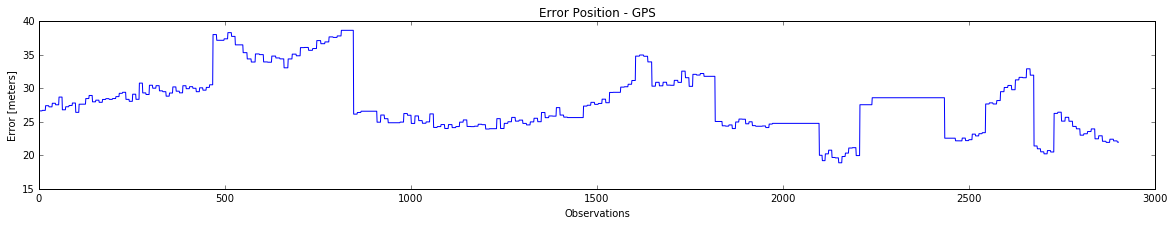

In [31]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGPS)
plt.ylabel("Error [meters]")
plt.xlabel("Observations")
plt.title('Error Position - GPS')

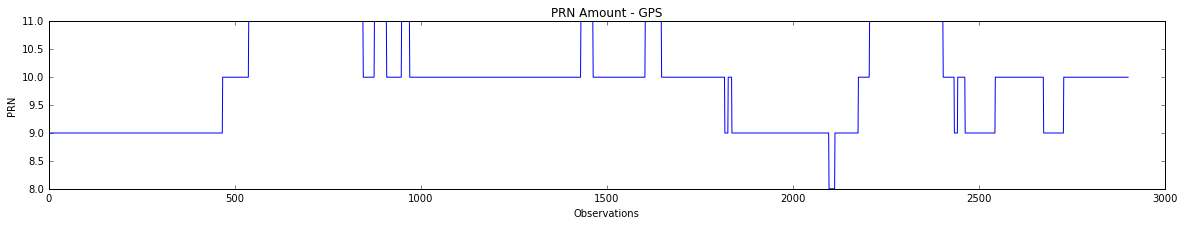

In [32]:
fig=plt.figure(figsize=(20,3))
plt.plot(vistos)
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - GPS')

### Position for <font color='blue'>GLONASS</font> -  <font color='red'>All Observations</font>

In [33]:
positionGlo = []
erroresGlo = []
c = 299792458.
SumError = 0.
vistos = []
ElevationsR = []
posXYGlo = []
sumaErroresMayoDiezmil = 0

for i in range (0, observations):
    #print A_GPS.PRN[i]
    p1 = np.array(A_Glonass.P1[i])
    pos = np.array(A_Glonass.POS[i])
    clock = np.array(A_Glonass.CLOCK[i])
    vistos.append(len(A_Glonass.PRN[i]))
    ElevationsR.append(A_Glonass.ELEV[i])
    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    pos_cpu = ls_computed_pos[:3]
    pos_cpu = To_WGS83(pos_cpu) #from PZ.02 to WGS83
    ls_error = np.linalg.norm(pos_cpu - real_pos)
    
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil
        lastError = ls_error
        posXYGlo.append([pos_cpu[:1]-real_pos[:1],pos_cpu[1:2]-real_pos[1:2]])
        reciverBias = pos_cpu/c
        SumError += ls_error
        positionGlo.append([pos_cpu,ls_error,reciverBias])
        erroresGlo.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1
        erroresGlo.append(lastError)
        
names=["X","GLONASS" ]
posXYGlo = pd.DataFrame(posXYGlo, columns=names)

print "Maximum Error: ",max(erroresGlo), "[meters]"
print "Minimum Error: ",min(erroresGlo), "[meters]"
print "Errores de posición superiores a 10mil: ", sumaErroresMayoDiezmil
names = ["PosComputed","PosError","ClockBias"]
positionGlo = pd.DataFrame(positionGlo,columns=names)
print "Average Error Position for GLONASS: ", SumError/len(erroresGlo), "[meters]","how much: ",len(erroresGPS)-sumaErroresMayoDiezmil

NameError: name 'To_WGS83' is not defined

In [ ]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGlo)
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error - GLONASS')

In [ ]:
fig=plt.figure(figsize=(20,3))
plt.plot(vistos)
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - Glonas')

In [ ]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGPS) #Blue  GPS
plt.plot(erroresGlo) #Green GLONASS
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error GPS (Blue)vs GLONASS (Green)')

In [ ]:
#fig=plt.figure(figsize=(8,8))
fig =plt.figure(figsize=(13,6))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.subplot(231)
plt.scatter(posXYGPS.X,posXYGPS.GPS, s=1, alpha=0.5, color = 'red')
plt.ylabel('Y error [meters]')
plt.xlabel('X error [meters]')
plt.title('Position Error GPS')

plt.subplot(232)
plt.scatter(posXYGlo.X,posXYGlo.GLONASS, s=1, alpha=0.5, color = 'blue')
plt.xlabel('X error [meters]')
plt.title('Position Error GLONASS')

plt.subplot(233)
plt.scatter(posXYGPS.X,posXYGPS.GPS, s=1, alpha=0.5, color = 'red')
plt.scatter(posXYGlo.X,posXYGlo.GLONASS, s=1, alpha=0.5, color = 'blue')
plt.xlabel('X error [meters]')
plt.title('Position Error GPS vs GLONASS')
plt.legend()
plt.show()